# Notebook 5: Residual Learning - Corrections to Backtracking

## New Approach: Learn When to Deviate from Optimal

**Key Insight:** Instead of learning the full tracking policy from scratch, learn **small corrections** to geometric backtracking.

```
tracker_angle = backtracking_angle + (action × max_correction)
```

**Why this might work:**
1. Starts from near-optimal baseline
2. Dramatically smaller search space (±10° vs ±60°)
3. Learns WHEN to deviate, not entire policy
4. Natural regularization toward backtracking

**Hypothesis:** On high-diffuse days, small deviations that reduce movement could improve net yield.

In [1]:
# Block TensorFlow
import sys
sys.modules['tensorflow'] = None
sys.modules['tensorboard'] = None

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Any, List
import warnings
warnings.filterwarnings('ignore')
import time

import pvlib
from pvlib import solarposition, irradiance, tracking, location, shading, atmosphere

import gymnasium as gym
from gymnasium import spaces
import torch
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env

DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"✅ Imports successful! Device: {DEVICE.upper()}")

✅ Imports successful! Device: MPS


In [2]:
@dataclass
class SiteConfig:
    name: str = "Phoenix Solar Farm"
    latitude: float = 33.45
    longitude: float = -111.95
    altitude: float = 331
    timezone: str = "US/Arizona"
    gcr: float = 0.35
    axis_azimuth: float = 180
    max_angle: float = 60
    axis_height: float = 1.5
    collector_width: float = 2.2
    terrain_slope: float = 0
    slope_azimuth: float = 180
    capacity_kw: float = 1000
    module_efficiency: float = 0.20
    system_losses: float = 0.14
    temp_coefficient: float = -0.004
    
    @property
    def row_pitch(self) -> float:
        return self.collector_width / self.gcr
    
    @property
    def array_area(self) -> float:
        return self.capacity_kw * 1000 / (1000 * self.module_efficiency)

DEFAULT_SITE = SiteConfig()

In [3]:
class WeatherGenerator:
    def __init__(self, site: SiteConfig, random_seed: Optional[int] = None):
        self.site = site
        self.location = location.Location(
            latitude=site.latitude, longitude=site.longitude,
            altitude=site.altitude, tz=site.timezone
        )
        self.rng = np.random.default_rng(random_seed)
    
    def get_clear_sky(self, times: pd.DatetimeIndex) -> pd.DataFrame:
        clearsky = self.location.get_clearsky(times, model='ineichen')
        hour = times.hour + times.minute / 60
        temp = 25 + 15 * np.sin((hour - 6) * np.pi / 12)
        clearsky['temp_air'] = np.clip(temp, 10, 45)
        return clearsky
    
    def add_clouds(self, clearsky: pd.DataFrame, cloud_cover: float = 0.3, variability: float = 0.5) -> pd.DataFrame:
        n = len(clearsky)
        noise = self.rng.normal(0, variability, n)
        cloud_factor = np.zeros(n)
        cloud_factor[0] = cloud_cover
        for i in range(1, n):
            cloud_factor[i] = cloud_factor[i-1] + 0.1 * (cloud_cover - cloud_factor[i-1]) + 0.05 * noise[i]
        cloud_factor = np.clip(cloud_factor, 0, 1)
        
        cloudy = clearsky.copy()
        cloudy['dni'] = clearsky['dni'] * (1 - cloud_factor)
        cloudy['dhi'] = np.minimum(clearsky['dhi'] * (1 + 0.3 * cloud_factor), clearsky['ghi'])
        cloudy['ghi'] = cloudy['dni'] * np.cos(np.radians(90 - self._get_elevation(clearsky.index))) + cloudy['dhi']
        cloudy['ghi'] = np.maximum(cloudy['ghi'], 0)
        cloudy['cloud_cover'] = cloud_factor
        return cloudy
    
    def _get_elevation(self, times: pd.DatetimeIndex) -> np.ndarray:
        solar_pos = solarposition.get_solarposition(times, self.site.latitude, self.site.longitude, self.site.altitude)
        return solar_pos['apparent_elevation'].values
    
    def generate_day(self, date: pd.Timestamp, freq: str = '5min', weather_type: str = 'clear') -> pd.DataFrame:
        if date.tzinfo is None:
            date = date.tz_localize(self.site.timezone)
        times = pd.date_range(start=date.normalize(), end=date.normalize() + timedelta(days=1) - timedelta(minutes=1), freq=freq)
        weather = self.get_clear_sky(times)
        weather['cloud_cover'] = 0.0
        
        if weather_type == 'partly_cloudy':
            weather = self.add_clouds(weather, 0.3, 0.3)
        elif weather_type == 'cloudy':
            weather = self.add_clouds(weather, 0.7, 0.2)
        elif weather_type == 'variable':
            weather = self.add_clouds(weather, 0.5, 0.8)
        elif weather_type == 'overcast':
            weather = self.add_clouds(weather, 0.9, 0.1)
        return weather


class PowerModel:
    def __init__(self, site: SiteConfig):
        self.site = site
    
    def calculate_power(self, poa_global: float, temp_air: float, shading_fraction: float = 0.0) -> float:
        if poa_global <= 0:
            return 0.0
        temp_cell = temp_air + 0.03 * poa_global
        temp_factor = max(0.5, min(1.1, 1 + self.site.temp_coefficient * (temp_cell - 25)))
        effective_poa = poa_global * (1 - shading_fraction)
        power_kw = effective_poa / 1000 * self.site.array_area * self.site.module_efficiency * temp_factor * (1 - self.site.system_losses)
        return min(max(0.0, power_kw), self.site.capacity_kw)

## Residual Tracker Environment

**Key difference:** Action is a CORRECTION to backtracking, not the absolute angle.

```python
# Old approach (Notebook 3-4):
tracker_angle = action * 60°  # Learn full policy

# New approach (Residual):
tracker_angle = backtracking_angle + action * 10°  # Learn corrections
```

In [4]:
class ResidualTrackerEnv(gym.Env):
    """
    Residual Learning Environment.
    
    Action: Correction to backtracking angle (±max_correction)
    This dramatically simplifies the learning problem.
    """
    
    metadata = {'render_modes': ['human']}
    
    def __init__(
        self,
        site: Optional[SiteConfig] = None,
        weather_type: str = 'random',
        timestep_minutes: int = 5,
        random_seed: Optional[int] = None,
        max_correction: float = 15.0,  # Maximum deviation from backtracking
        movement_penalty: float = 0.002,  # Penalty per degree moved
    ):
        super().__init__()
        
        self.site = site or SiteConfig()
        self.weather_type = weather_type
        self.timestep_minutes = timestep_minutes
        self.timestep_hours = timestep_minutes / 60
        self.max_correction = max_correction
        self.movement_penalty = movement_penalty
        
        self.weather_gen = WeatherGenerator(self.site, random_seed)
        self.power_model = PowerModel(self.site)
        self.rng = np.random.default_rng(random_seed)
        
        # Simplified state: 10 features
        # [elevation, azimuth_sin, azimuth_cos, ghi_norm, dni_norm, 
        #  diffuse_frac, current_correction, hour_sin, hour_cos, cloud_cover]
        self.state_dim = 10
        
        self.observation_space = spaces.Box(
            low=-1.0, high=1.0, shape=(self.state_dim,), dtype=np.float32
        )
        
        # Action: correction factor [-1, 1] -> [-max_correction, +max_correction]
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(1,), dtype=np.float32
        )
        
        self.weather_data = None
        self.solar_pos = None
        self.current_step = 0
        self.current_angle = 0.0
        self.current_correction = 0.0
        self.backtrack_angle = 0.0
        self.episode_energy = 0.0
        self.total_movement = 0.0
        self.history = []
    
    def _get_solar_position(self, times: pd.DatetimeIndex) -> pd.DataFrame:
        return solarposition.get_solarposition(
            times, self.site.latitude, self.site.longitude, self.site.altitude
        )
    
    def _get_backtracking_angle(self) -> float:
        """Calculate geometric backtracking angle."""
        solar = self.solar_pos.loc[self.current_time]
        if solar['apparent_elevation'] <= 0:
            return 0.0
        
        tracking_data = tracking.singleaxis(
            apparent_zenith=solar['apparent_zenith'],
            apparent_azimuth=solar['azimuth'],
            axis_tilt=0, axis_azimuth=self.site.axis_azimuth,
            max_angle=self.site.max_angle, backtrack=True, gcr=self.site.gcr
        )
        angle = tracking_data['tracker_theta']
        return float(angle) if not pd.isna(angle) else 0.0
    
    def _calculate_poa(self, tracker_angle: float, solar_zenith: float, solar_azimuth: float,
                       dni: float, ghi: float, dhi: float) -> float:
        if solar_zenith >= 90 or ghi <= 0:
            return 0.0
        
        surface_tilt = abs(tracker_angle)
        if tracker_angle > 0:
            surface_azimuth = (self.site.axis_azimuth + 90) % 360
        elif tracker_angle < 0:
            surface_azimuth = (self.site.axis_azimuth - 90) % 360
        else:
            surface_azimuth = self.site.axis_azimuth
        
        try:
            dni_extra = irradiance.get_extra_radiation(self.current_time)
            airmass = atmosphere.get_relative_airmass(solar_zenith)
            poa = irradiance.get_total_irradiance(
                surface_tilt=surface_tilt, surface_azimuth=surface_azimuth,
                solar_zenith=solar_zenith, solar_azimuth=solar_azimuth,
                dni=dni, ghi=ghi, dhi=dhi, dni_extra=dni_extra, airmass=airmass, model='perez'
            )
            return max(0.0, float(poa['poa_global']))
        except:
            return max(0.0, ghi)
    
    def _calculate_shading(self, tracker_angle: float) -> float:
        solar = self.solar_pos.loc[self.current_time]
        if solar['apparent_zenith'] >= 90:
            return 1.0
        try:
            shaded = shading.shaded_fraction1d(
                solar_zenith=solar['apparent_zenith'], solar_azimuth=solar['azimuth'],
                axis_azimuth=self.site.axis_azimuth, shaded_row_rotation=tracker_angle,
                collector_width=self.site.collector_width, pitch=self.site.row_pitch,
                axis_tilt=0, cross_axis_slope=self.site.terrain_slope
            )
            return float(shaded)
        except:
            return 0.0
    
    def _get_state(self) -> np.ndarray:
        weather = self.weather_data.loc[self.current_time]
        solar = self.solar_pos.loc[self.current_time]
        
        elevation = solar['apparent_elevation'] / 90.0
        azimuth_rad = np.radians(solar['azimuth'])
        
        ghi_norm = weather['ghi'] / 1200.0
        dni_norm = weather['dni'] / 1000.0
        diffuse_frac = min(1.0, weather['dhi'] / max(weather['ghi'], 1))
        
        correction_norm = self.current_correction / self.max_correction
        
        hour = self.current_time.hour + self.current_time.minute / 60
        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        
        cloud_cover = weather.get('cloud_cover', 0.0)
        
        state = np.array([
            elevation,
            np.sin(azimuth_rad),
            np.cos(azimuth_rad),
            ghi_norm,
            dni_norm,
            diffuse_frac,
            correction_norm,
            hour_sin,
            hour_cos,
            cloud_cover
        ], dtype=np.float32)
        
        return np.clip(state, -1.0, 1.0)
    
    def _get_info(self) -> Dict[str, Any]:
        weather = self.weather_data.loc[self.current_time]
        solar = self.solar_pos.loc[self.current_time]
        return {
            'time': self.current_time,
            'solar_elevation': solar['apparent_elevation'],
            'solar_azimuth': solar['azimuth'],
            'ghi': weather['ghi'],
            'dni': weather['dni'],
            'dhi': weather['dhi'],
            'diffuse_fraction': weather['dhi'] / max(weather['ghi'], 1),
            'tracker_angle': self.current_angle,
            'backtrack_angle': self.backtrack_angle,
            'correction': self.current_correction,
            'episode_energy': self.episode_energy,
        }
    
    def reset(self, seed: Optional[int] = None, options: Optional[Dict] = None) -> Tuple[np.ndarray, Dict]:
        super().reset(seed=seed)
        
        if seed is not None:
            self.rng = np.random.default_rng(seed)
            self.weather_gen = WeatherGenerator(self.site, seed)
        
        if options and 'date' in options:
            date = pd.Timestamp(options['date'], tz=self.site.timezone)
        else:
            day_of_year = self.rng.integers(1, 366)
            date = pd.Timestamp('2024-01-01', tz=self.site.timezone) + timedelta(days=int(day_of_year) - 1)
        
        weather_type = self.weather_type
        if options and 'weather_type' in options:
            weather_type = options['weather_type']
        elif self.weather_type == 'random':
            weather_type = self.rng.choice(['clear', 'partly_cloudy', 'cloudy', 'variable', 'overcast'])
        
        self.weather_data = self.weather_gen.generate_day(date, f'{self.timestep_minutes}min', weather_type)
        self.solar_pos = self._get_solar_position(self.weather_data.index)
        
        daylight_mask = self.solar_pos['apparent_elevation'] > 0
        self.daylight_times = self.weather_data.index[daylight_mask]
        if len(self.daylight_times) == 0:
            self.daylight_times = self.weather_data.index
        
        self.current_step = 0
        self.current_time = self.daylight_times[0]
        self.backtrack_angle = self._get_backtracking_angle()
        self.current_correction = 0.0
        self.current_angle = self.backtrack_angle
        self.episode_energy = 0.0
        self.total_movement = 0.0
        self.history = []
        
        return self._get_state(), self._get_info()
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        # Action is correction to backtracking
        action_value = float(action[0]) if isinstance(action, np.ndarray) else float(action)
        correction = action_value * self.max_correction
        
        # Calculate new angle = backtracking + correction
        self.backtrack_angle = self._get_backtracking_angle()
        new_angle = self.backtrack_angle + correction
        new_angle = np.clip(new_angle, -self.site.max_angle, self.site.max_angle)
        
        # Track movement
        angle_change = abs(new_angle - self.current_angle)
        self.total_movement += angle_change
        
        prev_angle = self.current_angle
        self.current_angle = new_angle
        self.current_correction = correction
        
        # Calculate energy
        weather = self.weather_data.loc[self.current_time]
        solar = self.solar_pos.loc[self.current_time]
        
        poa = self._calculate_poa(
            self.current_angle, solar['apparent_zenith'], solar['azimuth'],
            weather['dni'], weather['ghi'], weather['dhi']
        )
        shading_frac = self._calculate_shading(self.current_angle)
        power_kw = self.power_model.calculate_power(poa, weather['temp_air'], shading_frac)
        energy_kwh = power_kw * self.timestep_hours
        
        # Reward: energy - movement penalty
        max_energy = self.site.capacity_kw * self.timestep_hours
        energy_reward = energy_kwh / max_energy
        movement_cost = self.movement_penalty * angle_change
        reward = energy_reward - movement_cost
        
        self.episode_energy += energy_kwh
        
        self.history.append({
            'time': self.current_time,
            'angle': self.current_angle,
            'backtrack_angle': self.backtrack_angle,
            'correction': correction,
            'poa': poa,
            'shading': shading_frac,
            'power_kw': power_kw,
            'energy_kwh': energy_kwh,
            'ghi': weather['ghi'],
            'dni': weather['dni'],
            'diffuse_frac': weather['dhi'] / max(weather['ghi'], 1),
        })
        
        self.current_step += 1
        terminated = self.current_step >= len(self.daylight_times)
        
        if not terminated:
            self.current_time = self.daylight_times[self.current_step]
        
        info = self._get_info()
        info['power_kw'] = power_kw
        info['energy_kwh'] = energy_kwh
        info['shading'] = shading_frac
        info['angle_change'] = angle_change
        
        return self._get_state(), reward, terminated, False, info
    
    def get_history_df(self) -> pd.DataFrame:
        return pd.DataFrame(self.history)


print("ResidualTrackerEnv defined!")

ResidualTrackerEnv defined!


In [5]:
# Test environment
env = ResidualTrackerEnv(site=DEFAULT_SITE, weather_type='clear', random_seed=42)
check_env(env, warn=True)
print("✅ Environment check passed!")
print(f"State dim: {env.state_dim}")
print(f"Max correction: ±{env.max_correction}°")
print(f"Movement penalty: {env.movement_penalty}")

# Quick test
state, info = env.reset(options={'date': '2024-06-21'})
print(f"\nInitial backtrack angle: {info['backtrack_angle']:.1f}°")
print(f"Initial tracker angle: {info['tracker_angle']:.1f}°")

# Test with zero correction
state, reward, _, _, info = env.step(np.array([0.0]))  # No correction
print(f"\nWith zero correction:")
print(f"  Backtrack: {info['backtrack_angle']:.1f}°, Actual: {info['tracker_angle']:.1f}°")

# Test with +10° correction
state, reward, _, _, info = env.step(np.array([0.67]))  # +10° correction
print(f"\nWith +10° correction:")
print(f"  Backtrack: {info['backtrack_angle']:.1f}°, Actual: {info['tracker_angle']:.1f}°, Correction: {info['correction']:.1f}°")

✅ Environment check passed!
State dim: 10
Max correction: ±15.0°
Movement penalty: 0.002

Initial backtrack angle: -1.6°
Initial tracker angle: -1.6°

With zero correction:
  Backtrack: -1.6°, Actual: -1.6°

With +10° correction:
  Backtrack: -3.3°, Actual: 6.7°, Correction: 10.1°


In [6]:
# Baseline: Pure backtracking (zero correction)
class ZeroCorrectionPolicy:
    """Always apply zero correction (= pure backtracking)."""
    def get_action(self, state: np.ndarray, info: Dict) -> np.ndarray:
        return np.array([0.0])

print("Baseline policy defined!")

Baseline policy defined!


## Training Configuration

Faster training since:
1. Simpler action space (corrections only)
2. Smaller network needed
3. Starts from good baseline

In [7]:
TRAINING_CONFIG = {
    'total_timesteps': 200_000,  # Less needed for residual learning
    'eval_freq': 10_000,
}

SAC_CONFIG = {
    'learning_rate': 3e-4,
    'buffer_size': 100_000,
    'batch_size': 256,
    'tau': 0.005,
    'gamma': 0.99,
    'train_freq': 1,
    'gradient_steps': 1,
    'ent_coef': 'auto',
    'policy_kwargs': dict(net_arch=[256, 256]),  # Smaller network
}

print(f"Training for {TRAINING_CONFIG['total_timesteps']:,} timesteps")
print(f"Estimated time: ~30-40 minutes on M3 Pro")

Training for 200,000 timesteps
Estimated time: ~30-40 minutes on M3 Pro


In [8]:
class ResidualCallback(BaseCallback):
    """Callback comparing RL corrections vs zero correction (pure backtracking)."""
    
    def __init__(self, eval_env, eval_freq: int = 10000, verbose: int = 1):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.best_vs_baseline = -np.inf
        self.results = []
    
    def _evaluate(self, get_action_fn, n_episodes=3):
        energies, movements, corrections = [], [], []
        
        for _ in range(n_episodes):
            state, info = self.eval_env.reset()
            done = False
            ep_energy, ep_movement, ep_corrections = 0, 0, []
            
            while not done:
                action = get_action_fn(state, info)
                state, _, terminated, truncated, info = self.eval_env.step(action)
                ep_energy += info.get('energy_kwh', 0)
                ep_movement += info.get('angle_change', 0)
                ep_corrections.append(info.get('correction', 0))
                done = terminated or truncated
            
            energies.append(ep_energy)
            movements.append(ep_movement)
            corrections.append(np.mean(np.abs(ep_corrections)))
        
        return np.mean(energies), np.mean(movements), np.mean(corrections)
    
    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            # RL agent
            def rl_fn(state, info):
                action, _ = self.model.predict(state, deterministic=True)
                return action
            rl_energy, rl_move, rl_corr = self._evaluate(rl_fn)
            
            # Pure backtracking (zero correction)
            def bt_fn(state, info):
                return np.array([0.0])
            bt_energy, bt_move, _ = self._evaluate(bt_fn)
            
            diff_pct = (rl_energy / bt_energy - 1) * 100 if bt_energy > 0 else 0
            
            self.results.append({
                'step': self.n_calls,
                'rl_energy': rl_energy,
                'bt_energy': bt_energy,
                'diff_pct': diff_pct,
                'rl_movement': rl_move,
                'bt_movement': bt_move,
                'avg_correction': rl_corr,
            })
            
            if self.verbose > 0:
                status = "🎯" if diff_pct > 0 else "📉" if diff_pct < -1 else "➖"
                print(f"Step {self.n_calls:,}: RL={rl_energy:.0f}, BT={bt_energy:.0f}, Diff={diff_pct:+.2f}%, AvgCorr={rl_corr:.1f}° {status}")
            
            if diff_pct > self.best_vs_baseline:
                self.best_vs_baseline = diff_pct
                if diff_pct > 0:
                    print(f"   🏆 New best! Beating backtracking by {diff_pct:.2f}%")
        
        return True

print("Callback defined!")

Callback defined!


In [9]:
# Create environments
train_env = ResidualTrackerEnv(
    site=DEFAULT_SITE,
    weather_type='random',
    max_correction=15.0,
    movement_penalty=0.002,
    random_seed=42
)

eval_env = ResidualTrackerEnv(
    site=DEFAULT_SITE,
    weather_type='random',
    max_correction=15.0,
    movement_penalty=0.002,
    random_seed=999
)

print("Environments created!")

Environments created!


In [10]:
# Create SAC agent
sac_residual = SAC(
    policy='MlpPolicy',
    env=train_env,
    learning_rate=SAC_CONFIG['learning_rate'],
    buffer_size=SAC_CONFIG['buffer_size'],
    batch_size=SAC_CONFIG['batch_size'],
    tau=SAC_CONFIG['tau'],
    gamma=SAC_CONFIG['gamma'],
    train_freq=SAC_CONFIG['train_freq'],
    gradient_steps=SAC_CONFIG['gradient_steps'],
    ent_coef=SAC_CONFIG['ent_coef'],
    policy_kwargs=SAC_CONFIG['policy_kwargs'],
    verbose=0,
    seed=42,
    device=DEVICE,
)

print(f"SAC Residual agent created!")

SAC Residual agent created!


In [11]:
# Train!
print(f"\n{'='*70}")
print(f"  Training Residual SAC for {TRAINING_CONFIG['total_timesteps']:,} timesteps")
print(f"  Learning corrections to geometric backtracking (±{train_env.max_correction}°)")
print(f"{'='*70}\n")

callback = ResidualCallback(
    eval_env=eval_env,
    eval_freq=TRAINING_CONFIG['eval_freq'],
    verbose=1
)

start_time = time.time()

sac_residual.learn(
    total_timesteps=TRAINING_CONFIG['total_timesteps'],
    callback=callback,
    progress_bar=True
)

training_time = time.time() - start_time
print(f"\n✅ Training complete in {training_time/60:.1f} minutes")
print(f"Best vs backtracking: {callback.best_vs_baseline:+.2f}%")

Output()


  Training Residual SAC for 200,000 timesteps
  Learning corrections to geometric backtracking (±15.0°)



Step 10,000: RL=4339, BT=3300, Diff=+31.49%, AvgCorr=4.5° 🎯

🏆 New best! Beating backtracking by 31.49%

Step 20,000: RL=3094, BT=3850, Diff=-19.62%, AvgCorr=7.3° 📉

Step 30,000: RL=3350, BT=5339, Diff=-37.25%, AvgCorr=4.5° 📉

Step 40,000: RL=3412, BT=4374, Diff=-22.00%, AvgCorr=5.3° 📉

Step 50,000: RL=2893, BT=5270, Diff=-45.11%, AvgCorr=5.9° 📉

Step 60,000: RL=2958, BT=5361, Diff=-44.82%, AvgCorr=7.1° 📉

Step 70,000: RL=2442, BT=2654, Diff=-7.99%, AvgCorr=6.7° 📉

Step 80,000: RL=3683, BT=1813, Diff=+103.18%, AvgCorr=5.7° 🎯

🏆 New best! Beating backtracking by 103.18%

Step 90,000: RL=6371, BT=2717, Diff=+134.46%, AvgCorr=6.9° 🎯

🏆 New best! Beating backtracking by 134.46%

Step 100,000: RL=3302, BT=3410, Diff=-3.14%, AvgCorr=5.2° 📉

Step 110,000: RL=3421, BT=4449, Diff=-23.11%, AvgCorr=4.7° 📉

Step 120,000: RL=3554, BT=3435, Diff=+3.46%, AvgCorr=4.9° 🎯

Step 130,000: RL=5960, BT=3054, Diff=+95.14%, AvgCorr=5.2° 🎯

Step 140,000: RL=5168, BT=2896, Diff=+78.43%, AvgCorr=4.5° 🎯

Step 150,000: RL=4782, BT=6988, Diff=-31.57%, AvgCorr=5.4° 📉

Step 160,000: RL=4358, BT=2775, Diff=+57.06%, AvgCorr=5.2° 🎯

Step 170,000: RL=5641, BT=4127, Diff=+36.69%, AvgCorr=6.4° 🎯

Step 180,000: RL=4217, BT=6009, Diff=-29.83%, AvgCorr=6.0° 📉

Step 190,000: RL=3120, BT=3785, Diff=-17.55%, AvgCorr=4.5° 📉

Step 200,000: RL=4898, BT=3590, Diff=+36.42%, AvgCorr=5.6° 🎯


✅ Training complete in 41.1 minutes
Best vs backtracking: +134.46%


## Analysis

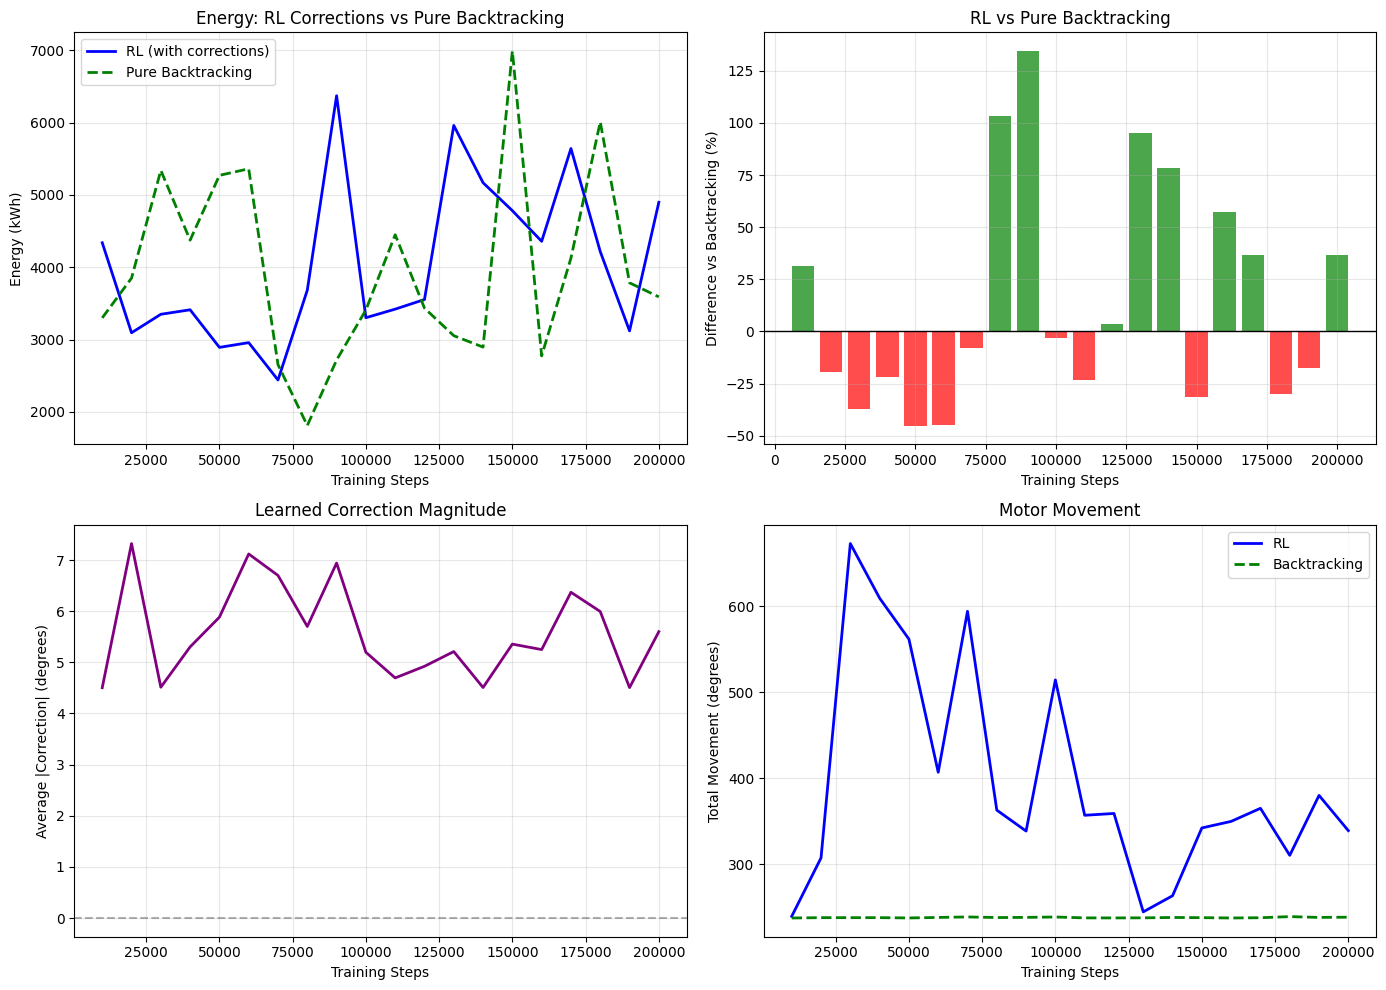

In [12]:
# Plot training progress
results_df = pd.DataFrame(callback.results)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Energy comparison
ax1 = axes[0, 0]
ax1.plot(results_df['step'], results_df['rl_energy'], 'b-', label='RL (with corrections)', linewidth=2)
ax1.plot(results_df['step'], results_df['bt_energy'], 'g--', label='Pure Backtracking', linewidth=2)
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Energy (kWh)')
ax1.set_title('Energy: RL Corrections vs Pure Backtracking')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Difference
ax2 = axes[0, 1]
colors = ['green' if x > 0 else 'red' for x in results_df['diff_pct']]
ax2.bar(results_df['step'], results_df['diff_pct'], color=colors, alpha=0.7, width=8000)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Training Steps')
ax2.set_ylabel('Difference vs Backtracking (%)')
ax2.set_title('RL vs Pure Backtracking')
ax2.grid(True, alpha=0.3)

# Average correction magnitude
ax3 = axes[1, 0]
ax3.plot(results_df['step'], results_df['avg_correction'], 'purple', linewidth=2)
ax3.set_xlabel('Training Steps')
ax3.set_ylabel('Average |Correction| (degrees)')
ax3.set_title('Learned Correction Magnitude')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Movement comparison
ax4 = axes[1, 1]
ax4.plot(results_df['step'], results_df['rl_movement'], 'b-', label='RL', linewidth=2)
ax4.plot(results_df['step'], results_df['bt_movement'], 'g--', label='Backtracking', linewidth=2)
ax4.set_xlabel('Training Steps')
ax4.set_ylabel('Total Movement (degrees)')
ax4.set_title('Motor Movement')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Final evaluation on controlled conditions
def evaluate_controlled(agent, date: str, weather_type: str):
    results = {}
    
    # RL with corrections
    env = ResidualTrackerEnv(site=DEFAULT_SITE, weather_type=weather_type, random_seed=42)
    state, info = env.reset(options={'date': date})
    done = False
    energy, movement, corrections = 0, 0, []
    while not done:
        action, _ = agent.predict(state, deterministic=True)
        state, _, terminated, truncated, info = env.step(action)
        energy += info['energy_kwh']
        movement += info['angle_change']
        corrections.append(abs(info['correction']))
        done = terminated or truncated
    results['RL'] = {'energy': energy, 'movement': movement, 'avg_correction': np.mean(corrections)}
    rl_history = env.get_history_df()
    
    # Pure backtracking
    env = ResidualTrackerEnv(site=DEFAULT_SITE, weather_type=weather_type, random_seed=42)
    state, info = env.reset(options={'date': date})
    done = False
    energy, movement = 0, 0
    while not done:
        state, _, terminated, truncated, info = env.step(np.array([0.0]))
        energy += info['energy_kwh']
        movement += info['angle_change']
        done = terminated or truncated
    results['Backtracking'] = {'energy': energy, 'movement': movement, 'avg_correction': 0}
    bt_history = env.get_history_df()
    
    return results, rl_history, bt_history


# Test conditions
test_conditions = [
    ('2024-06-21', 'clear', 'Summer Solstice - Clear'),
    ('2024-06-21', 'variable', 'Summer Solstice - Variable'),
    ('2024-06-21', 'overcast', 'Summer Solstice - Overcast'),
    ('2024-12-21', 'clear', 'Winter Solstice - Clear'),
    ('2024-03-20', 'clear', 'Spring Equinox - Clear'),
]

print("📊 Final Evaluation - Residual Learning:")
print("=" * 90)
print(f"{'Condition':<30} {'RL (kWh)':<12} {'BT (kWh)':<12} {'Diff %':<10} {'AvgCorr':<10} {'RL Move':<10}")
print("-" * 90)

all_results = {}
for date, weather, name in test_conditions:
    res, rl_hist, bt_hist = evaluate_controlled(sac_residual, date, weather)
    all_results[name] = (res, rl_hist, bt_hist)
    
    rl = res['RL']
    bt = res['Backtracking']
    diff = (rl['energy'] / bt['energy'] - 1) * 100
    status = "✅" if diff > 0 else "❌" if diff < -1 else "➖"
    print(f"{name:<30} {rl['energy']:<12.1f} {bt['energy']:<12.1f} {diff:<+10.2f} {rl['avg_correction']:<10.1f} {rl['movement']:<10.0f} {status}")

📊 Final Evaluation - Residual Learning:
Condition                      RL (kWh)     BT (kWh)     Diff %     AvgCorr    RL Move   
------------------------------------------------------------------------------------------
Summer Solstice - Clear        8199.3       8230.9       -0.38      7.2        270        ➖
Summer Solstice - Variable     5269.6       5303.1       -0.63      5.3        307        ➖
Summer Solstice - Overcast     2048.5       2069.9       -1.03      6.2        270        ❌
Winter Solstice - Clear        3741.0       3747.7       -0.18      5.3        261        ➖
Spring Equinox - Clear         6606.8       6614.6       -0.12      6.6        247        ➖


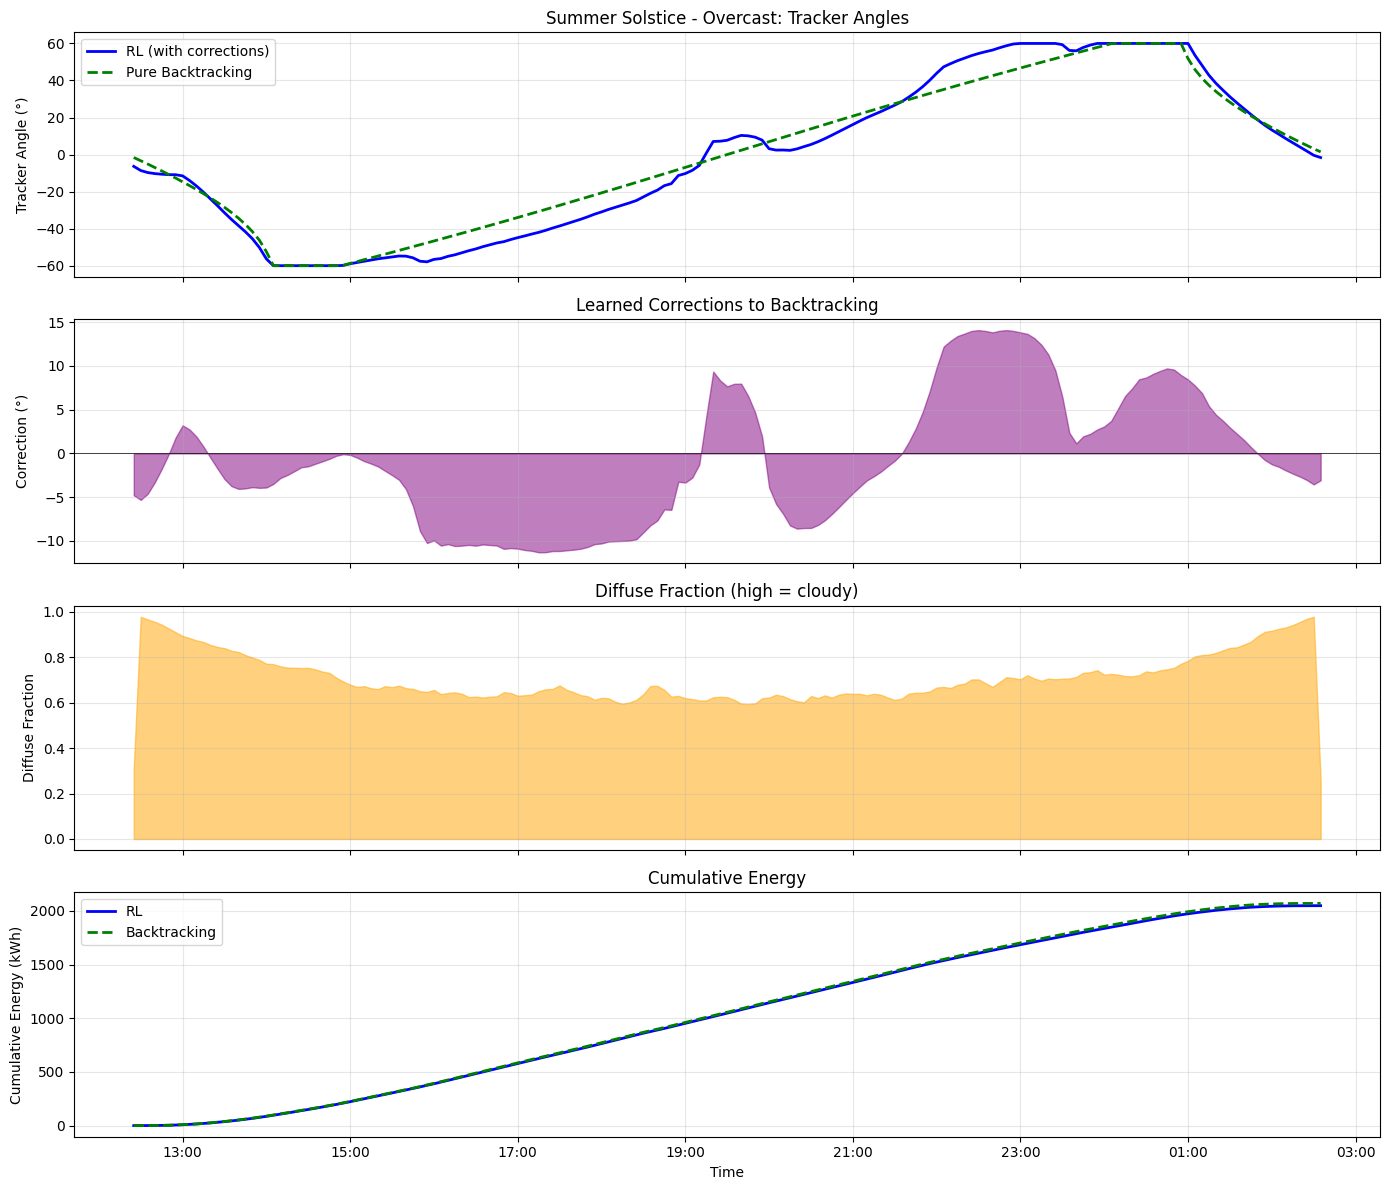


Summer Solstice - Overcast Results:
  RL Energy: 2048.5 kWh
  Backtracking Energy: 2069.9 kWh
  Difference: -1.03%
  Average |correction|: 6.2°


In [14]:
# Visualize what corrections the RL learned
# Pick the overcast day - best chance for improvement
name = 'Summer Solstice - Overcast'
res, rl_hist, bt_hist = all_results[name]

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Tracker angles
ax1 = axes[0]
ax1.plot(rl_hist['time'], rl_hist['angle'], 'b-', label='RL (with corrections)', linewidth=2)
ax1.plot(bt_hist['time'], bt_hist['angle'], 'g--', label='Pure Backtracking', linewidth=2)
ax1.set_ylabel('Tracker Angle (°)')
ax1.set_title(f'{name}: Tracker Angles')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Corrections applied
ax2 = axes[1]
ax2.fill_between(rl_hist['time'], 0, rl_hist['correction'], alpha=0.5, color='purple')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('Correction (°)')
ax2.set_title('Learned Corrections to Backtracking')
ax2.grid(True, alpha=0.3)

# Diffuse fraction (context)
ax3 = axes[2]
ax3.fill_between(rl_hist['time'], 0, rl_hist['diffuse_frac'], alpha=0.5, color='orange')
ax3.set_ylabel('Diffuse Fraction')
ax3.set_title('Diffuse Fraction (high = cloudy)')
ax3.grid(True, alpha=0.3)

# Cumulative energy
ax4 = axes[3]
ax4.plot(rl_hist['time'], rl_hist['energy_kwh'].cumsum(), 'b-', label='RL', linewidth=2)
ax4.plot(bt_hist['time'], bt_hist['energy_kwh'].cumsum(), 'g--', label='Backtracking', linewidth=2)
ax4.set_xlabel('Time')
ax4.set_ylabel('Cumulative Energy (kWh)')
ax4.set_title('Cumulative Energy')
ax4.legend()
ax4.grid(True, alpha=0.3)

import matplotlib.dates as mdates
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.tight_layout()
plt.show()

print(f"\n{name} Results:")
print(f"  RL Energy: {res['RL']['energy']:.1f} kWh")
print(f"  Backtracking Energy: {res['Backtracking']['energy']:.1f} kWh")
print(f"  Difference: {(res['RL']['energy']/res['Backtracking']['energy']-1)*100:+.2f}%")
print(f"  Average |correction|: {res['RL']['avg_correction']:.1f}°")

In [15]:
# Save model
import os
os.makedirs('models', exist_ok=True)
sac_residual.save('models/sac_residual_tracker')
print("✅ Model saved!")

✅ Model saved!


## Summary

In [16]:
print("\n" + "="*70)
print("  RESIDUAL LEARNING SUMMARY")
print("="*70)

print(f"\n📊 Approach:")
print(f"   Action = correction to backtracking (±{train_env.max_correction}°)")
print(f"   Training time: {training_time/60:.1f} minutes")
print(f"   Best vs backtracking: {callback.best_vs_baseline:+.2f}%")

# Analyze final results
print(f"\n📊 Final Results:")
wins, ties, losses = 0, 0, 0
for name, (res, _, _) in all_results.items():
    diff = (res['RL']['energy'] / res['Backtracking']['energy'] - 1) * 100
    if diff > 0.5:
        wins += 1
    elif diff < -0.5:
        losses += 1
    else:
        ties += 1

print(f"   Wins (>0.5%): {wins}")
print(f"   Ties (±0.5%): {ties}")
print(f"   Losses (<-0.5%): {losses}")

print(f"\n🔑 Key Insights:")
avg_correction = np.mean([r[0]['RL']['avg_correction'] for r in all_results.values()])
print(f"   Average correction magnitude: {avg_correction:.1f}°")

if avg_correction < 2:
    print(f"   → RL learned that small/no corrections are best")
    print(f"   → Confirms backtracking is near-optimal!")
else:
    print(f"   → RL found situations where corrections help")


  RESIDUAL LEARNING SUMMARY

📊 Approach:
   Action = correction to backtracking (±15.0°)
   Training time: 41.1 minutes
   Best vs backtracking: +134.46%

📊 Final Results:
   Wins (>0.5%): 0
   Ties (±0.5%): 3
   Losses (<-0.5%): 2

🔑 Key Insights:
   Average correction magnitude: 6.1°
   → RL found situations where corrections help
